In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# from ariadne.util.deeppcb import DeepPCBData, Defect, DefectType
from ariadne.util.datasets import DeepPCB
from ariadne.util.deeppcb import DefectType
from ariadne.util.datasets import DeepPCB
# from ariadne.util import showdefects
from ariadne.nn.util import show_results
from ariadne.cv import get_defect_blobs, featurize_region
# import ariadne.cv
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import torch
from torch import nn, Tensor
import torchvision
import skimage as ski
import collections
from enum import IntEnum
from tqdm.notebook import tqdm
from sklearn import svm
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rc('image', cmap='gray')

%matplotlib inline

In [53]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [54]:
DEEPPCB_ROOT = Path('/Users/moon/git/DeepPCB')
class ToNumpy(nn.Module):
    def forward(
        self, tmpl_image, obsv_image, target,
    ):
        tmpl_image = np.asarray(tmpl_image)
        obsv_image = np.asarray(obsv_image)
        return tmpl_image, obsv_image, target

dataset      = DeepPCB(DEEPPCB_ROOT, ToNumpy())
dataset_test = DeepPCB(DEEPPCB_ROOT, ToNumpy())

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
TEST_SPLIT = 500 # of 1500 image pairs
dataset = torch.utils.data.Subset(dataset, indices[:-TEST_SPLIT])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-TEST_SPLIT:])

def collate_fn(x):
    return x[0]

data_loader = torch.utils.data.DataLoader(dataset,
    batch_size=1, shuffle=True,
    collate_fn=collate_fn,
    num_workers=0)

data_loader_test = torch.utils.data.DataLoader(dataset_test,
    batch_size=1, shuffle=True,
    collate_fn=collate_fn,
    num_workers=0)

# train

In [76]:
X = []
y = []

# -- featurize
for tmpl_image, obsv_image, targets in data_loader:
    img_pair = (tmpl_image, obsv_image)
    
    blobs, labels, defect_mask = get_defect_blobs(img_pair)
    for region in ski.measure.regionprops(labels):
        minr, minc, maxr, maxc = region.bbox
        ious = torchvision.ops.box_iou(torch.tensor([[minc, minr, maxc, maxr]]), targets['boxes'])[0]
        best_match = ious.argmax().item()
        if torch.isclose(ious[best_match], torch.zeros(1)):
            print('skip unmatched')
            continue
            
        true_label = targets['labels'][best_match]
        
        features = featurize_region(img_pair, labels, region)
        if features is None:
            print('failed to featurize')
            continue
        
        X.append(features)
        y.append(true_label)

# -- fit
X_ = np.array(X)
clf = svm.SVC(kernel='rbf')
clf.fit(X_, y)

skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmatched
skip unmat

SVC()

In [78]:
with open('svmmodel.pickle', 'wb') as f:
    pickle.dump(clf, f)

# eval

In [145]:
import time
from ariadne.nn.driver.utils import MetricLogger
# from ariadne.nn.driver.coco_utils import get_coco_api_from_dataset
# from ariadne.nn.driver.coco_eval import CocoEvaluator
# from ariadne.eval import pycocotools_summarize
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint

def evaluate(model, data_loader):
    metric_logger = MetricLogger(delimiter="  ")
    header = "Test:"

    # coco = get_coco_api_from_dataset(data_loader.dataset)
    # iou_types = ['bbox']
    # coco_evaluator = CocoEvaluator(coco, iou_types)
    # metric = MeanAveragePrecision()
    metric = MeanAveragePrecision(iou_thresholds=[0.15])

    for tmpl_image, obsv_image, target in metric_logger.log_every(data_loader, 100, header):
        # tmpl_images = list(image.to(device) for image in tmpl_images)
        # obsv_images = list(image.to(device) for image in obsv_images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        pred = model(tmpl_image, obsv_image)
        # plt.imshow(obsv_image)

        # outputs = [{k: v.to(cpudev) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time
        
        metric.update([pred], [target])
        
        # show_results(torch.tensor(obsv_image).unsqueeze(0).repeat((3,1,1)), outputs, colors='lightgreen').show()
        # show_results(torch.tensor(obsv_image).unsqueeze(0).repeat((3,1,1)), targets, colors='lightblue').show()

        # res = {targets["image_id"].item(): outputs}
        # evaluator_time = time.time()
        # coco_evaluator.update(res)
        # evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time)#, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    # coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    # coco_evaluator.accumulate()
    # coco_evaluator.summarize()
    
    pprint(metric.compute())

    # mAP_IoU_50_all = pycocotools_summarize(coco_evaluator.coco_eval['bbox'], iouThr=.5)

    # return coco_evaluator
    return metric


with open('svmmodel.pickle', 'rb') as f:
    clf = pickle.load(f)

# model shim
def model(tmpl_image, obsv_image):
    img_pair = (tmpl_image, obsv_image)
    blobs, labels, defect_mask = get_defect_blobs(img_pair)
    
    targets = {'boxes': [], 'labels': []}

    for region in ski.measure.regionprops(labels):
        features = featurize_region(img_pair, labels, region)
        if features is None:
            print('failed to featurize')
            continue
        
        minr, minc, maxr, maxc = region.bbox
        targets['boxes'].append([minc, minr, maxc, maxr])
        targets['labels'].append(clf.predict(features.reshape(1, -1))[0])
        
    
    targets['boxes'] = torch.tensor(targets['boxes'])
    targets['labels'] = torch.tensor(targets['labels'])
    targets['scores'] = torch.ones_like(targets['labels'], dtype=torch.float)
    
    return targets

# show_results(torch.tensor(obsv_image).unsqueeze(0).repeat((3,1,1)), output, colors='lightgreen')
evaluate(model, data_loader_test)

failed to featurize
Test:  [  0/500]  eta: 0:00:39  model_time: 0.0706 (0.0706)  time: 0.0782  data: 0.0076
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
Test:  [100/500]  eta: 0:00:16  model_time: 0.0329 (0.0364)  time: 0.0390  data: 0.0059
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
failed to featurize
Test:  [200/500]  eta: 0:00:13  model_time: 0.0331 (0.0380)  time: 0.0429  data: 0.0062
failed to featurize
failed to featur

MeanAveragePrecision()

## trying to figure out why its fucked

In [96]:
# grab a specific pair
tmpl_image, obsv_image, target = next(iter(data_loader_test))

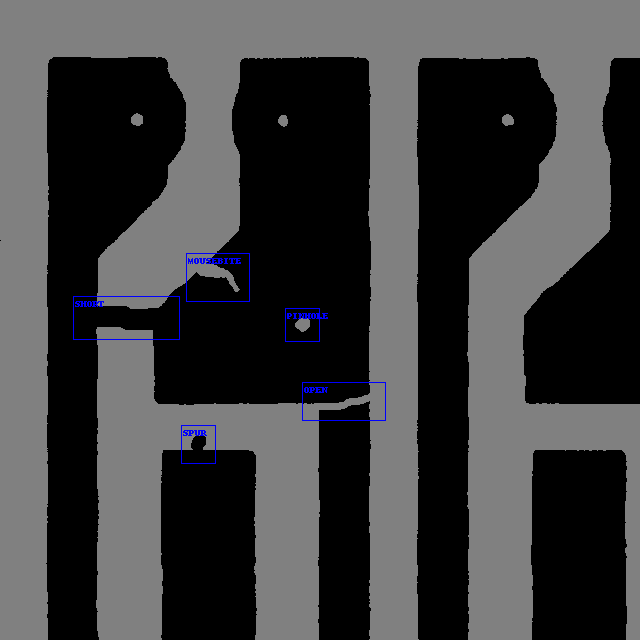

In [106]:
show_results(torch.tensor(obsv_image).unsqueeze(0).repeat((3,1,1)), target, colors='blue')

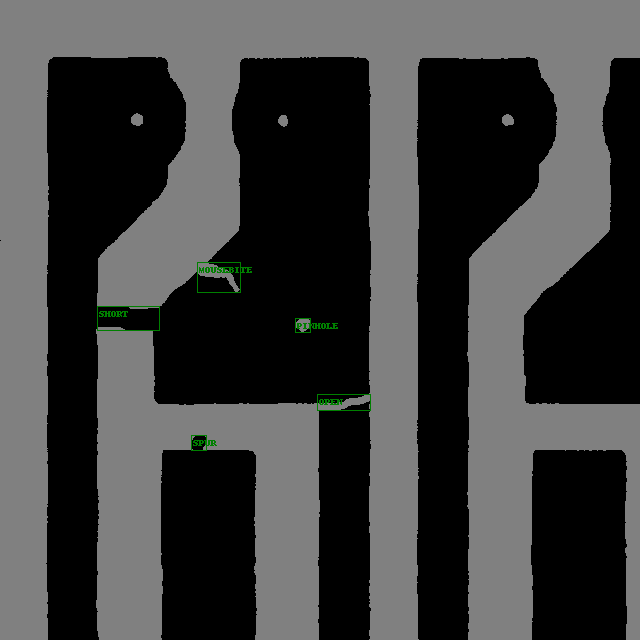

In [107]:
output = model(tmpl_image, obsv_image)
show_results(torch.tensor(obsv_image).unsqueeze(0).repeat((3,1,1)), output, colors='green')

In [131]:
metric.update([output], [target])
metric.compute()

{'map': tensor(1.),
 'map_50': tensor(-1),
 'map_75': tensor(-1),
 'map_small': tensor(-1.),
 'map_medium': tensor(1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(1.),
 'mar_10': tensor(1.),
 'mar_100': tensor(1.),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [132]:
output

{'boxes': tensor([[197, 262, 240, 292],
         [ 97, 306, 159, 330],
         [295, 318, 310, 332],
         [317, 394, 370, 410],
         [191, 435, 206, 450]]),
 'labels': tensor([3, 2, 6, 1, 4]),
 'scores': tensor([1., 1., 1., 1., 1.])}

In [133]:
target

{'boxes': tensor([[302., 382., 385., 420.],
         [ 73., 296., 179., 339.],
         [186., 253., 249., 301.],
         [181., 425., 215., 463.],
         [285., 308., 319., 341.]]),
 'area': tensor([3154., 4558., 3024., 1292., 1122.]),
 'labels': tensor([1, 2, 3, 4, 6]),
 'image_id': tensor([92000084])}

In [134]:
len(metric.groundtruths)

1

In [135]:
metric._compute_iou(0, 1, 100)

tensor([[0.2689]])